# HITS (Hubs and Authorities)

### Initialize

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType,TimestampType

spark = SparkSession \
    .builder \
    .appName("Spark_Processor") \
    .master("local[*]") \
    .getOrCreate()

sc = spark.sparkContext

schema = StructType([ \
        StructField("DEVICE_CODE", IntegerType(), True), 
        StructField("SYSTEM_ID",IntegerType(),True), \
        StructField("ORIGINE_CAR_KEY",IntegerType(),True), \
        StructField("FINAL_CAR_KEY", IntegerType(),True), \
        StructField("CHECK_STATUS_KEY", IntegerType(), True), \
        StructField("COMPANY_ID", StringType(), True), \
        StructField("PASS_DAY_TIME", TimestampType(), True)
    ])

22/02/11 18:52:30 WARN Utils: Your hostname, amin-X556UQK resolves to a loopback address: 127.0.1.1; using 192.168.43.227 instead (on interface wlp3s0)
22/02/11 18:52:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/11 18:52:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df = spark.read.csv('Traffic.csv',header=True,schema=schema)
df.show(1)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|     200501|       81|       10477885|     10477885|               5|       161|2021-06-01 03:54:39|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
only showing top 1 row



##### Keep only 7 days

In [3]:
from pyspark.sql.functions import dayofyear
df = df.withColumn('day', dayofyear(df.PASS_DAY_TIME))
df = df.filter(df.day != 159)
df.show(1)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|day|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+
|     200501|       81|       10477885|     10477885|               5|       161|2021-06-01 03:54:39|152|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+
only showing top 1 row



##### Remove outliers

In [4]:
from pyspark.sql.functions import hour,dayofweek, count
from pyspark.sql.window import Window

window = Window.partitionBy('FINAL_CAR_KEY')
df_with_car_count = df.withColumn('count', count('FINAL_CAR_KEY').over(window))
df_cleaned = df_with_car_count.filter(df_with_car_count['count'] < 1000)
df_cleaned.show(5)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+-----+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|day|count|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+-----+
|     803001|      102|        7631929|      7631929|               6|       161|2021-06-01 10:37:55|152|    1|
|   22010048|      284|        7631930|      7631930|               5|       161|2021-06-02 13:21:00|153|    1|
|     900158|      283|        7631979|      7631979|               5|       264|2021-06-06 12:30:50|157|    9|
|  100700881|      283|        7631979|      7631979|               5|       264|2021-06-06 17:46:08|157|    9|
|     900222|      283|        7631979|      7631979|               5|       264|2021-06-06 17:49:52|157|    9|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---

### Main Code

In [5]:
df_with_time_columns = df_cleaned.withColumn('time', (dayofweek(df.PASS_DAY_TIME)-1)*24 + hour(df.PASS_DAY_TIME))
df_with_time_columns = df_with_time_columns.select('DEVICE_CODE', 'FINAL_CAR_KEY', 'time')
df_with_time_columns.show(5)

+-----------+-------------+----+
|DEVICE_CODE|FINAL_CAR_KEY|time|
+-----------+-------------+----+
|     803001|      7631929|  58|
|   22010048|      7631930|  85|
|     631795|      7631935| 163|
|        175|      7631935|  56|
|     211401|      7631935|  41|
+-----------+-------------+----+
only showing top 5 rows



<h5 dir="rtl">
 در این قسمت، تعداد ثبت‌های هر دوربین در هرساعت مشخص هفته را به دست آورده‌ام.  
</h5> 


In [6]:
camera_daily_df = df_with_time_columns.groupBy(
    'DEVICE_CODE',
    'time'
).count()
camera_daily_df.show(5)

22/02/11 19:06:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/02/11 19:06:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+-----------+----+-----+
|DEVICE_CODE|time|count|
+-----------+----+-----+
|     211401|  90|  352|
|     631350|  55|   77|
|     631349|  90|  101|
|        231|  41| 1712|
|   22009971| 151|  421|
+-----------+----+-----+
only showing top 5 rows



##### Index cameras

In [7]:
from pyspark.ml.feature import StringIndexer

camera_daily_indexed_df = StringIndexer(inputCol='DEVICE_CODE', outputCol='camera').fit(camera_daily_df).transform(camera_daily_df)
camera_daily_indexed_df.show(5)

22/02/11 19:15:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/02/11 19:15:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+-----------+----+-----+------+
|DEVICE_CODE|time|count|camera|
+-----------+----+-----+------+
|     211401|  90|  352|  95.0|
|     631350|  55|   77| 285.0|
|     631349|  90|  101| 284.0|
|        231|  41| 1712| 122.0|
|   22009971| 151|  421| 100.0|
+-----------+----+-----+------+
only showing top 5 rows



<h5 dir="rtl">
 در این مرحله با کمک 
 df
 مرحله‌ی قبلی، ماتریسی را به دست آوردم که هر درایه‌ی آن نشان‌دهنده‌ی تعداد بار‌هایی است که یک دوربین خاص در یک زمان مشخص ثبت انجام داده‌است. دقت کنید که ماتریس به دست آمده 
 sparse
 است. 
</h5> 


In [8]:
from pyspark.mllib.linalg.distributed import CoordinateMatrix
utility_matrix = CoordinateMatrix(camera_daily_indexed_df.rdd.map(lambda x: (int(x['camera']), int(x['time']), x['count']) ))

22/02/11 19:19:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/02/11 19:19:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


<h5 dir="rtl">
 در اینجا نیز به کمک توابع موجود، تجزیه 
 svd
 ماتریس را به دست آوردم. 
</h5> 


In [9]:
svd = utility_matrix.toRowMatrix().computeSVD(10, computeU=True)
u = svd.U
s = svd.s
v = svd.V
# print(u)
# print(s)
# print(v)

22/02/11 19:19:45 WARN RowMatrix: The input data is not directly cached, which may hurt performance if its parent RDDs are also uncached.
22/02/11 19:19:45 WARN InstanceBuilder$NativeARPACK: Failed to load implementation from:dev.ludovic.netlib.arpack.JNIARPACK
22/02/11 19:19:58 WARN RowMatrix: The input data was not directly cached, which may hurt performance if its parent RDDs are also uncached.


<h5 dir="rtl">
 حال ارزش
 hubها
 و 
 authority
 ها را به دست می‌آوریم. در مورد آن‌ها در مستند صحبت کرده‌ام.  
</h5> 


In [13]:
hubs = u.rows.map(lambda x: x.toArray()[0] * -1).collect()
times = v.toArray()
times = times[:,0] * -1
print('number of cameras: ', len(hubs))
print('number of times: ', len(times))

print('camera ratings: ', hubs[:10])
print('time ratings: ', times[:10])

number of cameras:  1025
number of times:  168
camera ratings:  [0.0017490794983410045, 7.937459950481641e-05, 0.016455803741178582, 1.2538979415740256e-05, 5.455735189418114e-05, 0.04270576872110887, 0.006417681559012077, 0.0008320270858319268, 0.002936757988830863, 3.6633355127767755e-05]
time ratings:  [0.02181479 0.01454072 0.00793662 0.00851296 0.00693132 0.01020027
 0.02402674 0.03472469 0.04307125 0.05354024]


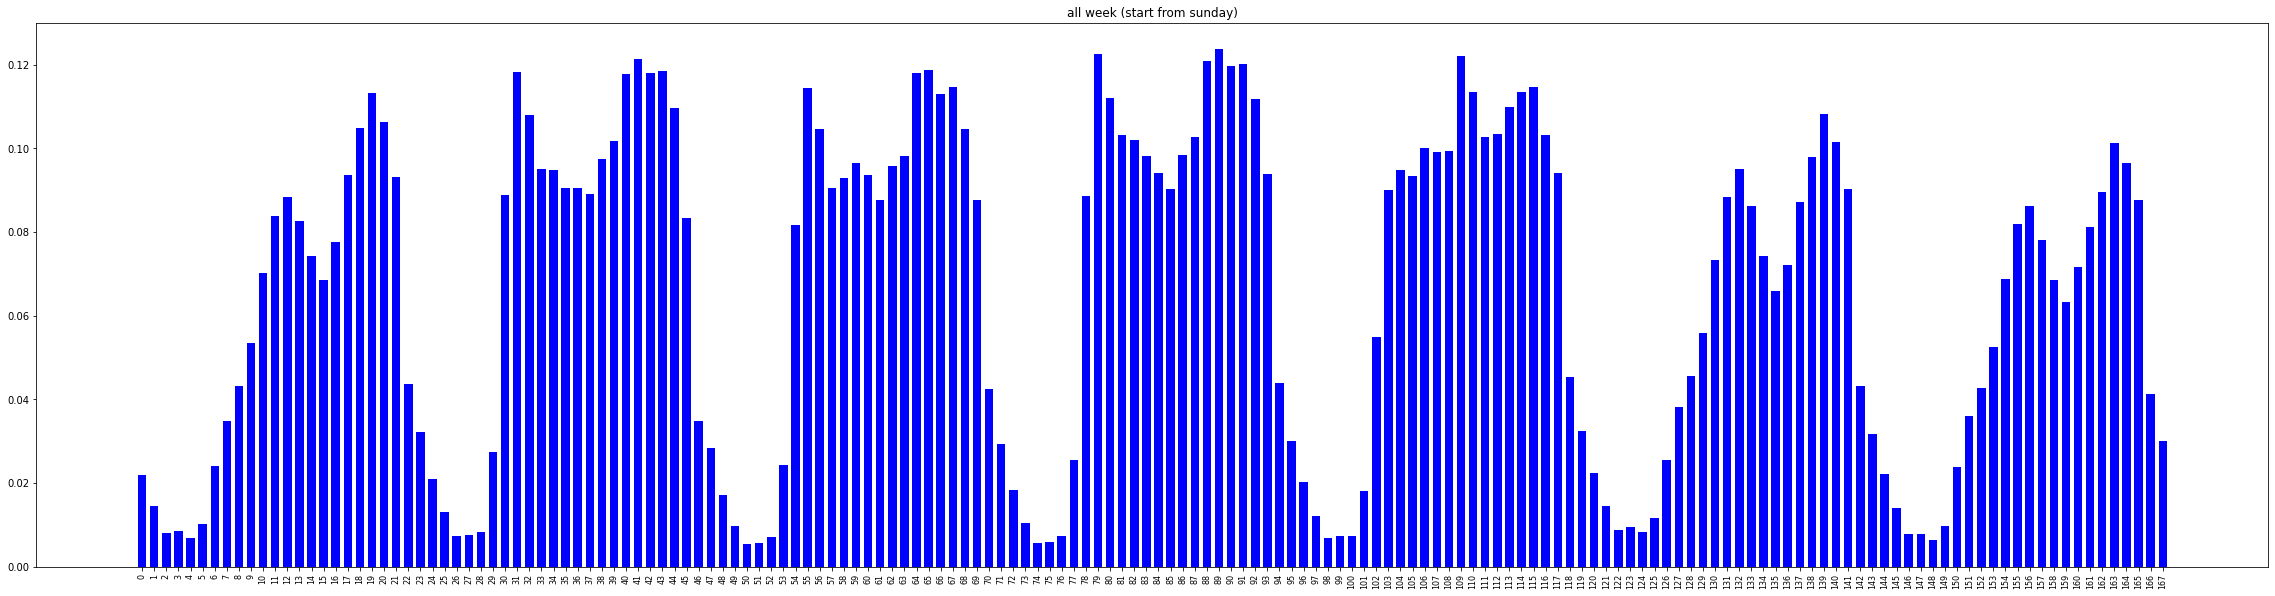

In [14]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize = (40, 10))
labels = list(map(lambda x: str(x), range(24*7)))
plt.bar(labels, times, color ='blue', width = 0.7)
plt.xticks(rotation='vertical',fontsize=8)
plt.title('all week (start from sunday)')
plt.show()

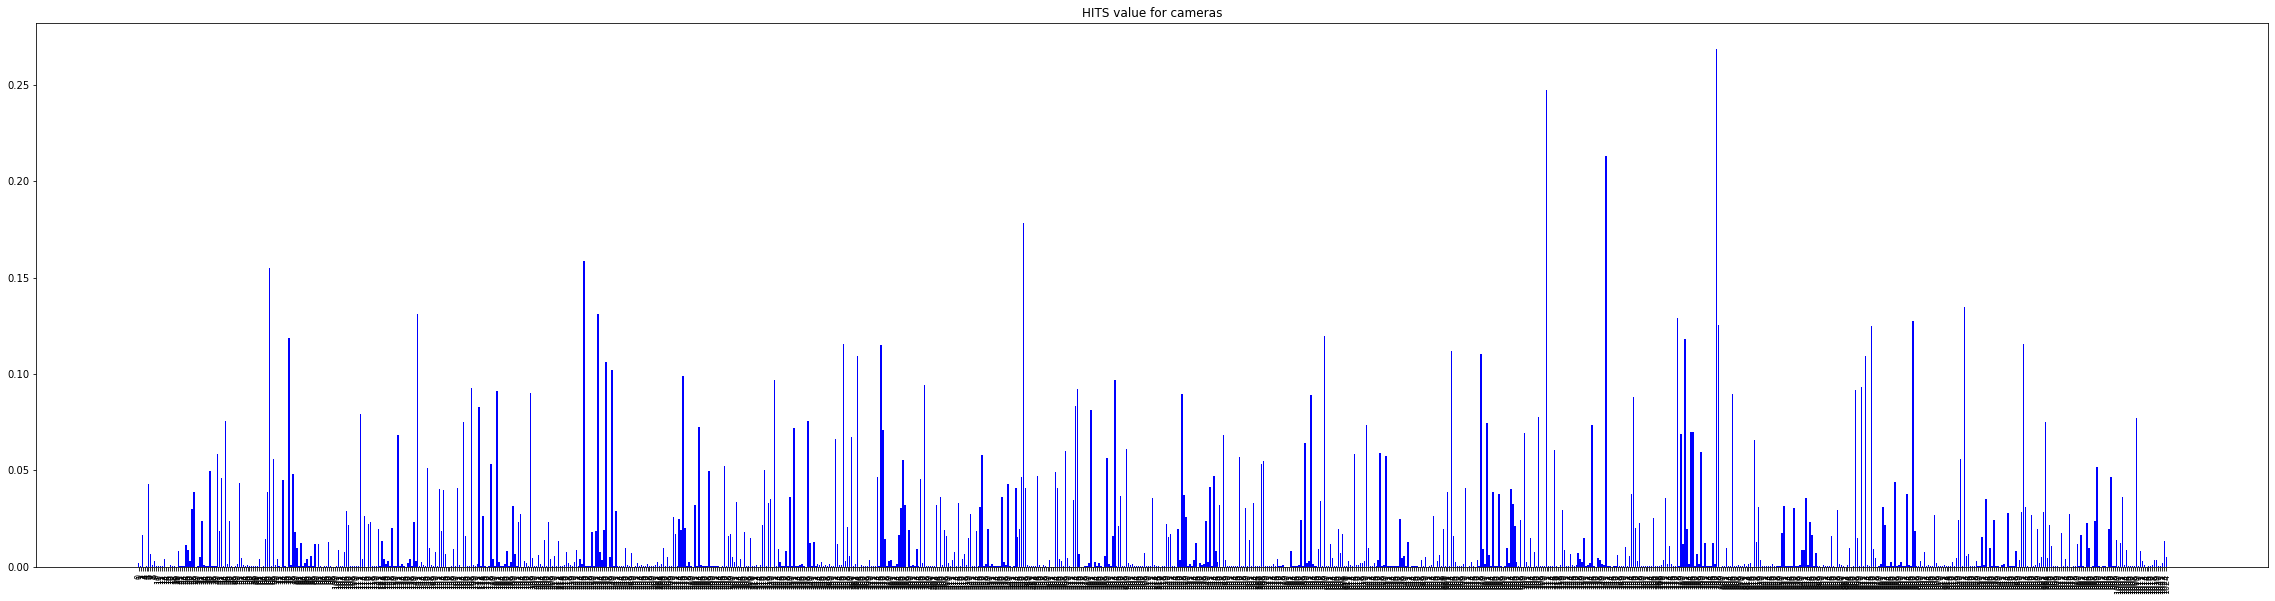

In [17]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize = (40, 10))
labels = list(map(lambda x: str(x), range(len(hubs))))
plt.bar(labels, hubs, color ='blue', width = 0.7)
plt.xticks(rotation='vertical',fontsize=8)
plt.title('HITS value for cameras')
plt.show()

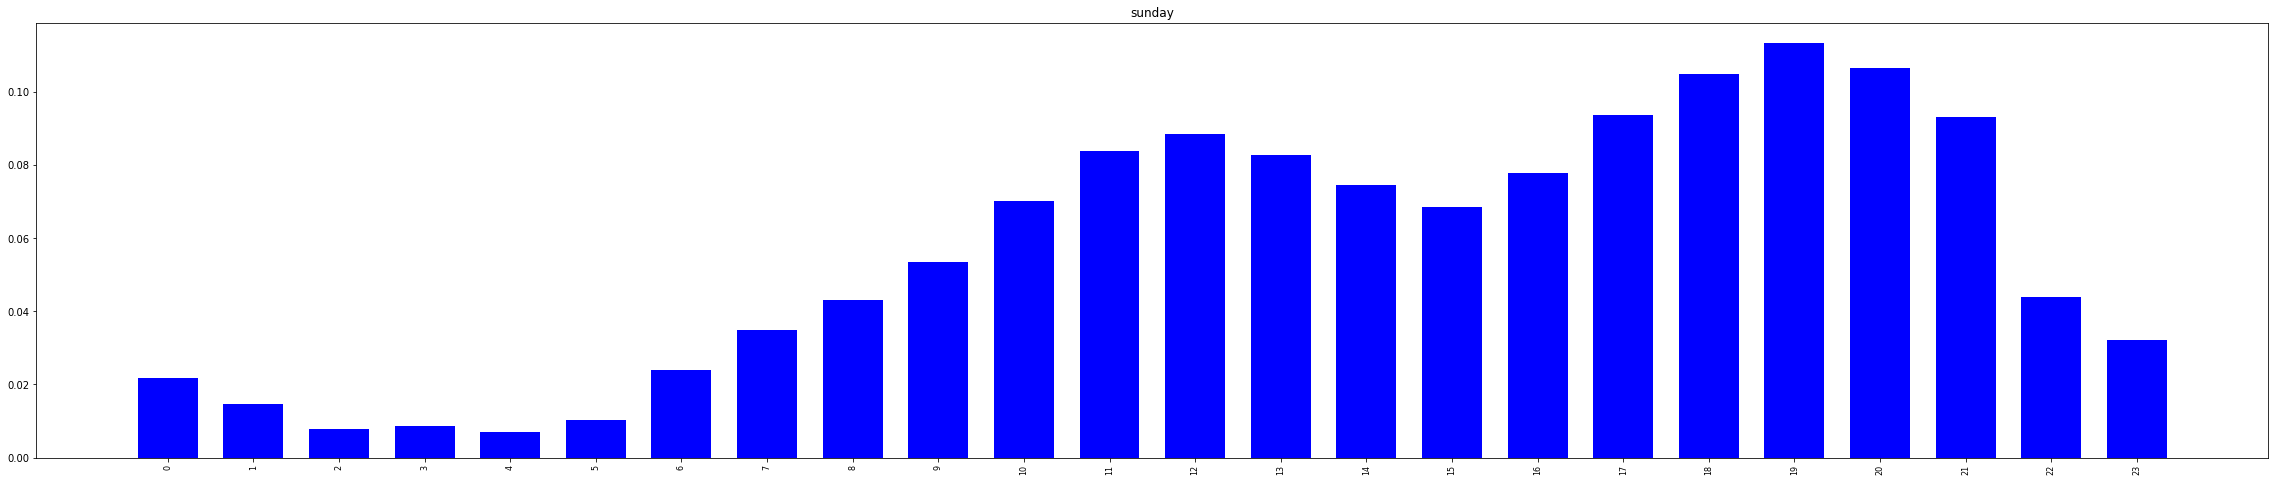

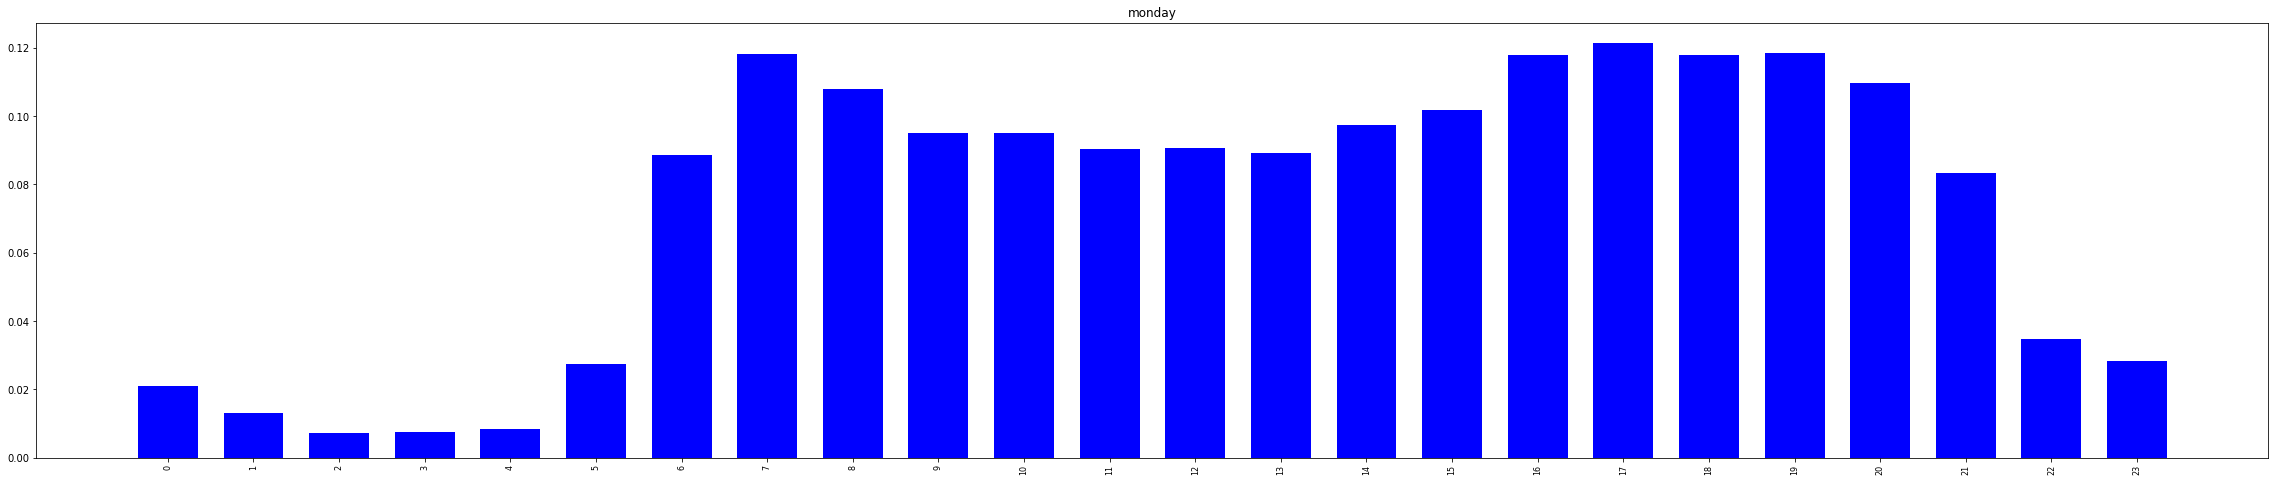

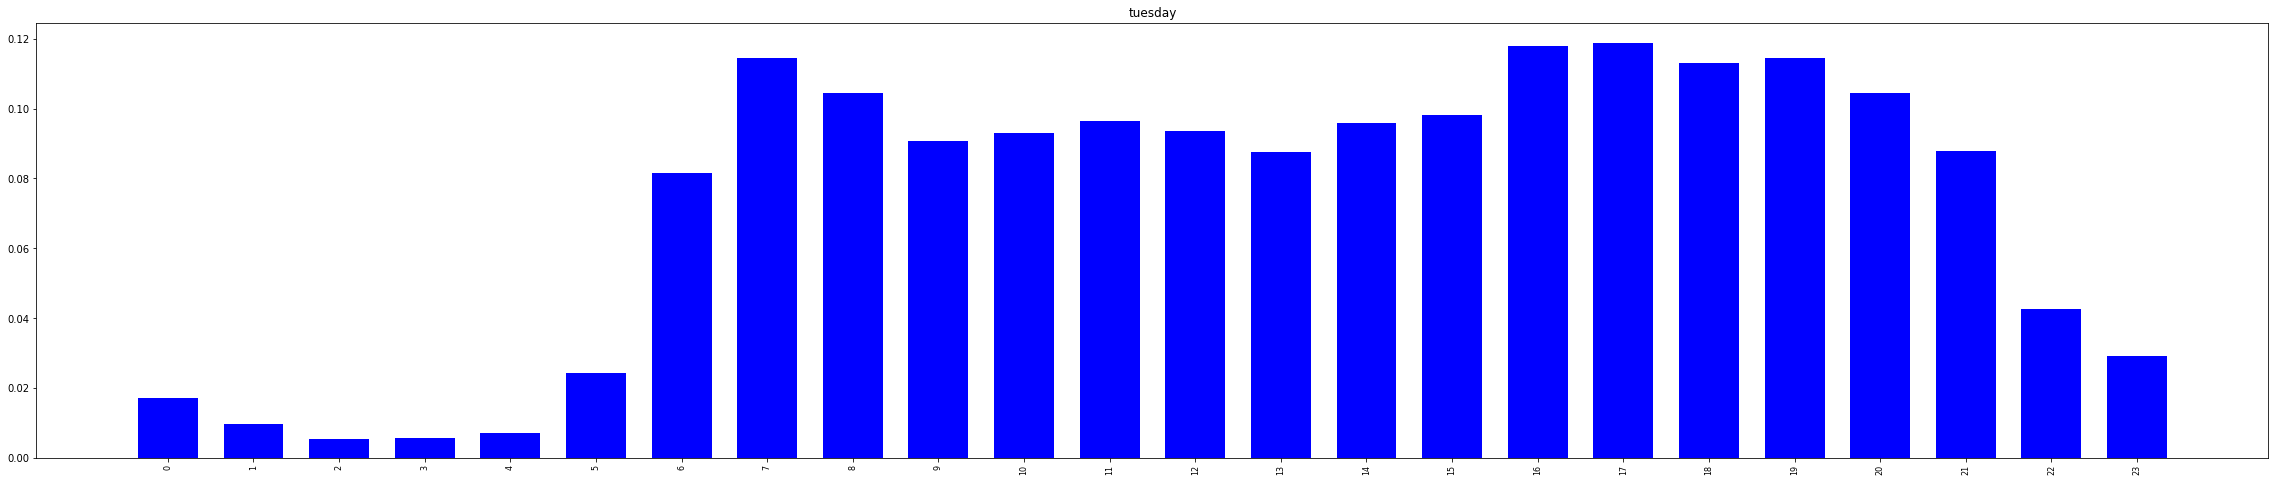

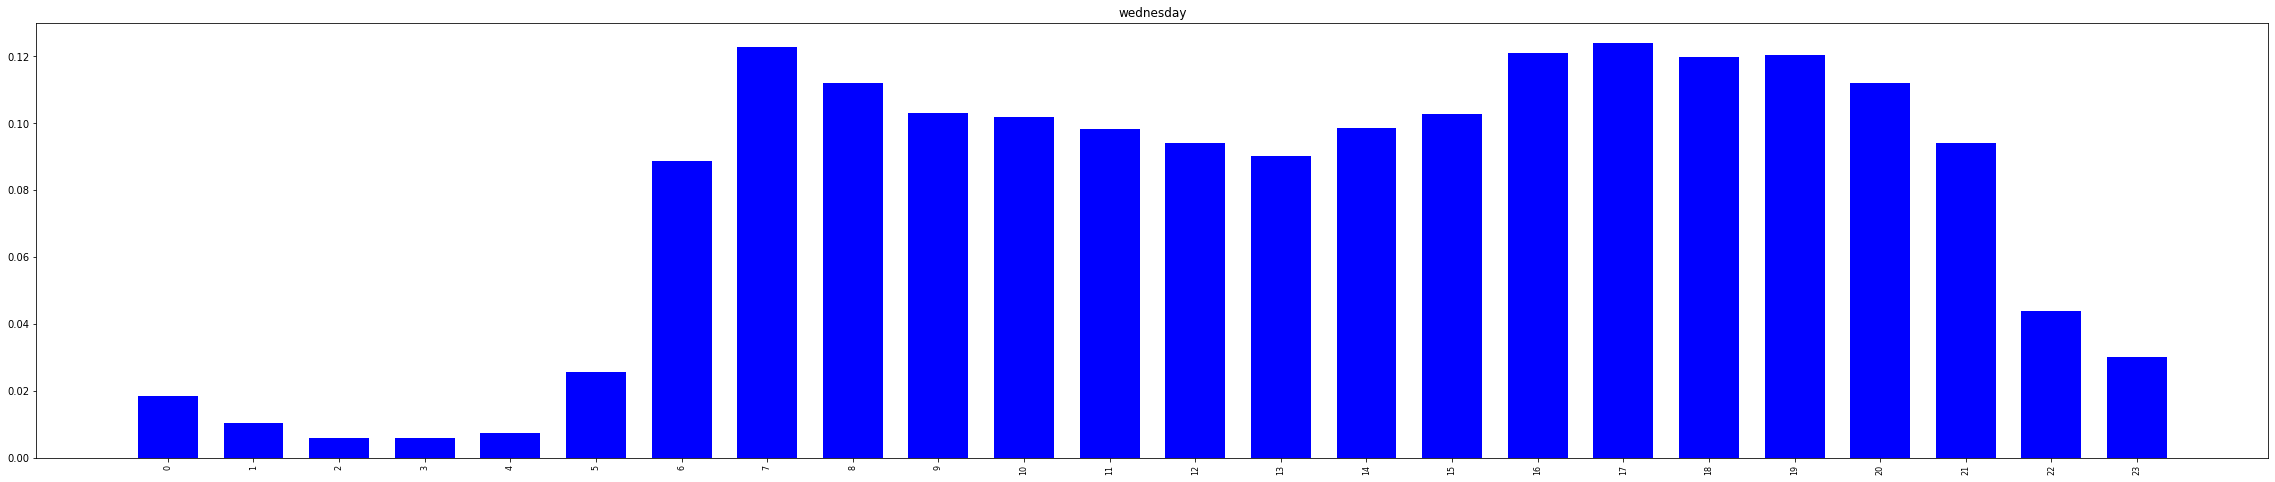

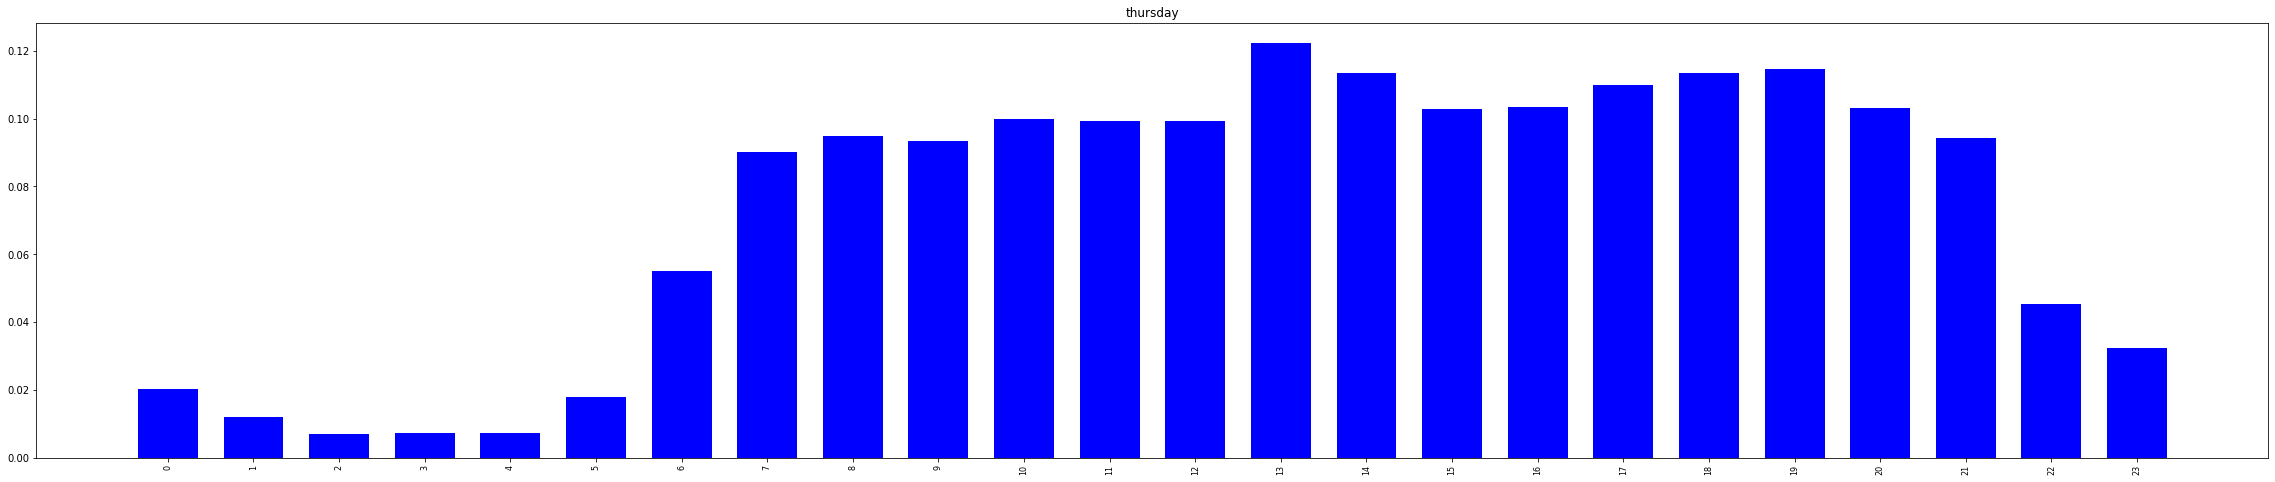

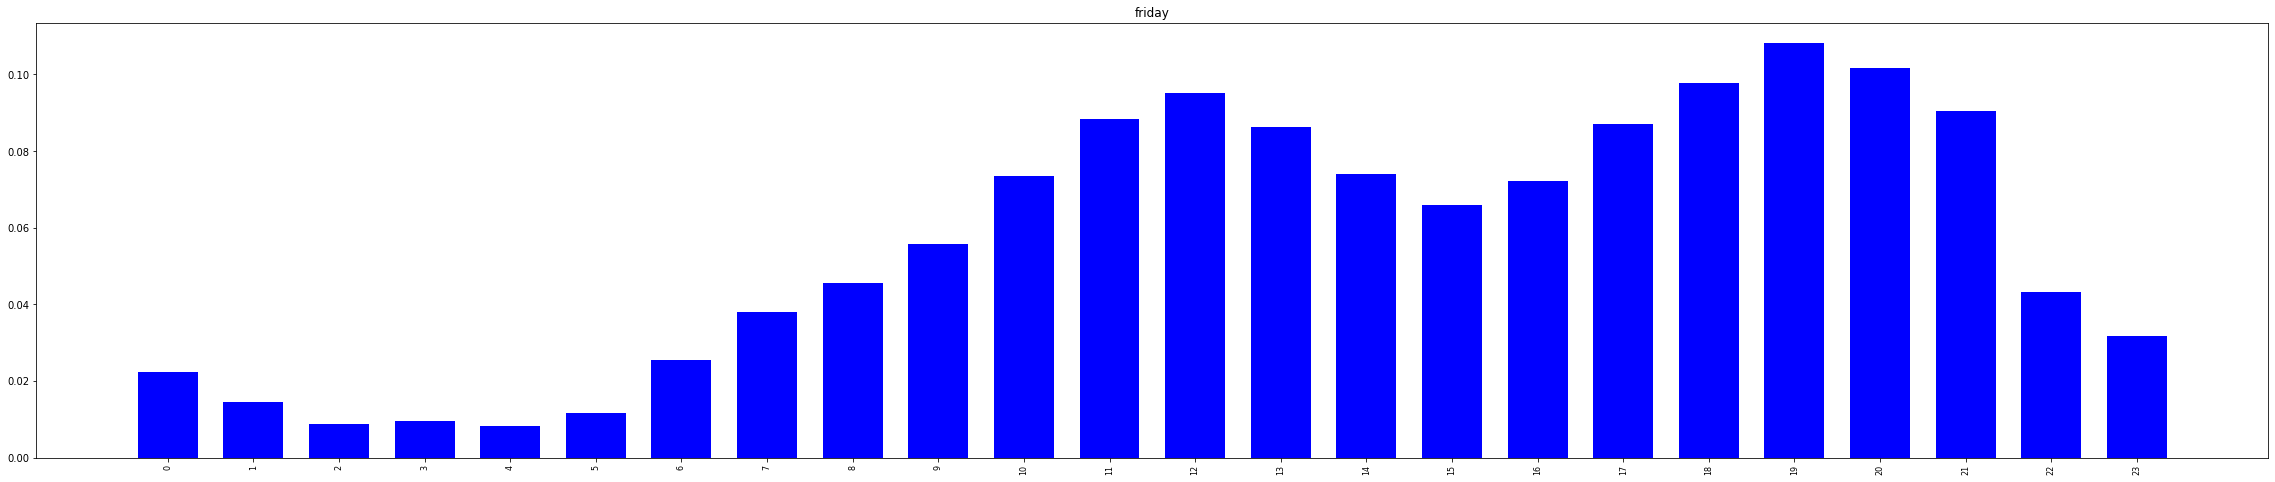

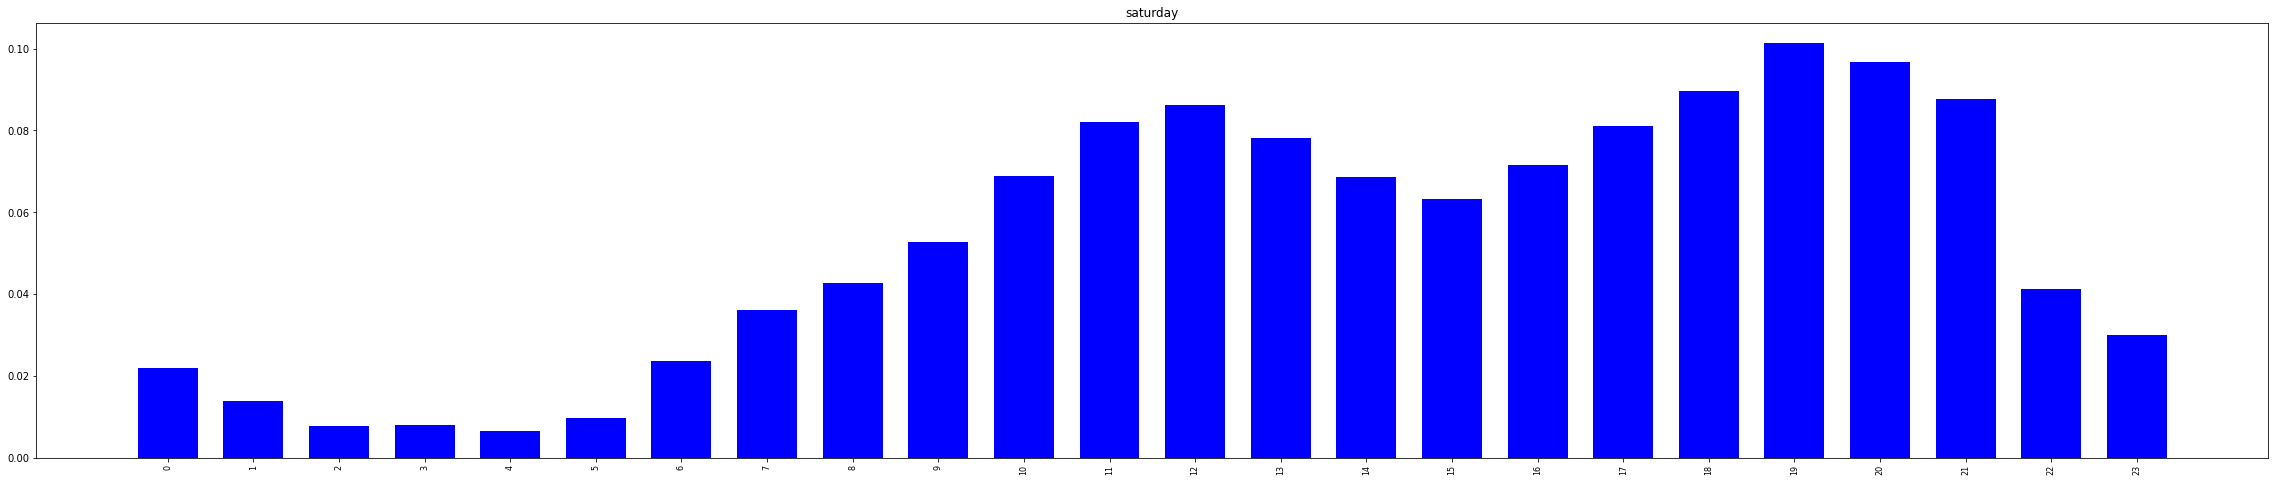

In [15]:
from matplotlib import pyplot as plt

weekdays = [
    'sunday',
    'monday',
    'tuesday',
    'wednesday',
    'thursday',
    'friday',
    'saturday',
    ]

for day_index, day in enumerate(weekdays):
    fig = plt.figure(figsize = (40, 8))
    labels = list(map(lambda x: str(x), range(24)))
    chart = times[day_index*24: (day_index+1)*24]
    plt.bar(labels, chart, color ='blue', width = 0.7)
    plt.xticks(rotation='vertical',fontsize=8)
    plt.title(day)
    plt.show()